In [14]:
from PIL import Image
import random
import math
import datetime
import json

import torch
import torchvision

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

np.random.seed(123)
random.seed(123)
torch.manual_seed(123)

def show_dataset(data, n=5):
    plt.figure(figsize=(16, 9))
    img = np.vstack([np.hstack([np.asarray(data[n * j + i][0]).transpose(1, 2, 0) for i in range(n)]) for j in range(n)])
    plt.imshow(img)
    plt.axis('off')

    
class RandomErasing(object):
    '''
    Class that performs Random Erasing in Random Erasing Data Augmentation by Zhong et al. 
    -------------------------------------------------------------------------------------
    probability: The probability that the operation will be performed.
    sl: min erasing area
    sh: max erasing area
    r1: min aspect ratio
    mean: erasing value
    source: https://github.com/zhunzhong07/Random-Erasing/blob/master/transforms.py
    -------------------------------------------------------------------------------------
    '''
    def __init__(self, probability = 0.5, sl = 0.02, sh = 0.4, r1 = 0.3, mean=[0.4914, 0.4822, 0.4465]):
        self.probability = probability
        self.mean = mean
        self.sl = sl
        self.sh = sh
        self.r1 = r1

    def __call__(self, img):

        if random.uniform(0, 1) > self.probability:
            return img

        for attempt in range(100):
            area = img.size()[1] * img.size()[2]

            target_area = random.uniform(self.sl, self.sh) * area
            aspect_ratio = random.uniform(self.r1, 1/self.r1)

            h = int(round(math.sqrt(target_area * aspect_ratio)))
            w = int(round(math.sqrt(target_area / aspect_ratio)))

            if w < img.size()[2] and h < img.size()[1]:
                x1 = random.randint(0, img.size()[1] - h)
                y1 = random.randint(0, img.size()[2] - w)
                if img.size()[0] == 3:
                    img[0, x1:x1+h, y1:y1+w] = self.mean[0]
                    img[1, x1:x1+h, y1:y1+w] = self.mean[1]
                    img[2, x1:x1+h, y1:y1+w] = self.mean[2]
                else:
                    img[0, x1:x1+h, y1:y1+w] = self.mean[0]
                return img

        return img
    
    
def train(net, optimizer, loss_func, scheduler, n_epochs, train_loader, test_loader=None):
    """Trains network for n_epochs epochs. test_loader can be passed to measure test accuracy/loss."""
    losses_train = []
    losses_test = []
    accuraccies_train = []
    accuraccies_test = []
    
    for epoch in range(0, n_epochs):
        scheduler.step()
        loss_train = 0
        correct_train = 0
        
        for i, (inputs, labels) in enumerate(train_loader, 0):
            inputs = inputs.cuda()
            labels = labels.cuda()
            optimizer.zero_grad()
            
            output = net(inputs)
            loss = loss_func(output, labels)
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
            _, pred_labels = torch.max(output.data, 1)
            correct_train += (pred_labels == labels).sum().item()
            
        loss_train /= len(train_loader.dataset)
        accuracy_train = correct_train / len(train_loader.dataset)
        
        losses_train.append(loss_train)
        accuraccies_train.append(accuracy_train)
        
        timestamp_string = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        output_str = "[{}] EPOCH {} / {}; train_loss: {}, train_accuracy: {}".format(timestamp_string, epoch + 1,
                                                                                     n_epochs, loss_train,
                                                                                     accuracy_train)
        if test_loader:
            accuracy_test, loss_test = test(net, test_loader, loss_func)
            losses_test.append(loss_test)
            accuraccies_test.append(accuracy_test)
            test_output_string = "; test_loss: {}, test_accuracy: {}".format(loss_test, accuracy_test)
            output_str += test_output_string
        print(output_str)
    return accuraccies_train, losses_train, accuraccies_test, losses_test
        
def test(net, test_loader, loss_func):
    """Returns accuracy and loss of a network on test set"""
    correct = 0
    loss = 0
    
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            loss += loss_func(outputs, labels).item()
    return correct / len(test_loader.dataset), loss / len(test_loader.dataset)

def save_net(net, path):
    """Saves network parameters to the file"""
    torch.save(net.state_dict(), path) 
    
def save_results(results_tuple, path):
    """Saves training results to the json file"""
    with open(path, "w") as f:
        json.dump(results_tuple, f)
        
def load_results(path):
    with open(path, "r") as f:
        results = json.load(f)
    return results
        
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
sns.set()

device

device(type='cuda', index=0)

### Load and plot dataset

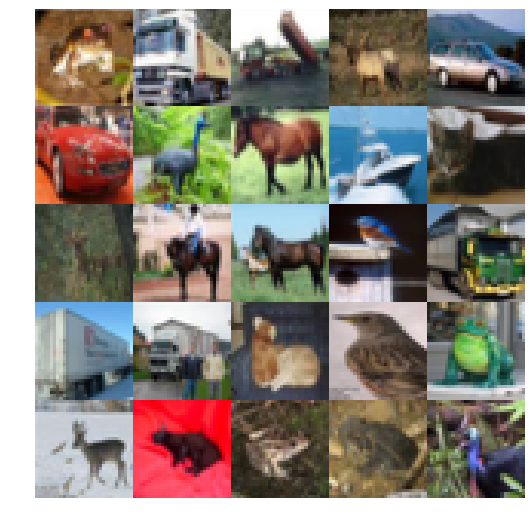

In [15]:
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
train_set = torchvision.datasets.CIFAR10(root='./data/', train=True,
                                        download=False, transform=transforms)
show_dataset(train_set)

### Plot augumented dataset

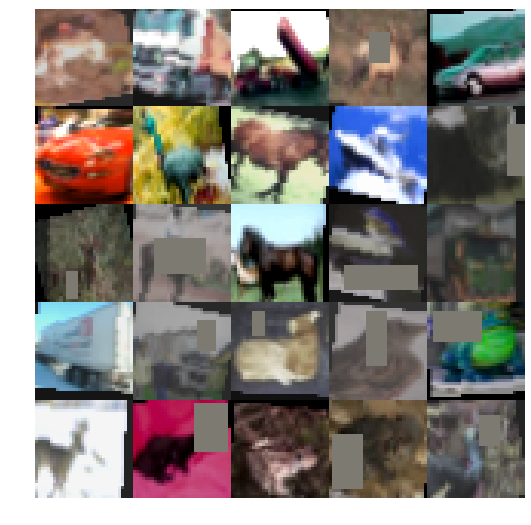

In [16]:
train_mean = np.mean(train_set.data, axis=(0,1,2)) / 255
train_std = np.std(train_set.data, axis=(0,1,2)) / 255

augumentation_transforms = [torchvision.transforms.RandomAffine(translate=(0.1, 0.1), degrees=(-15,15)),
                            torchvision.transforms.RandomResizedCrop(32, scale=(0.7, 1)),
                            torchvision.transforms.ColorJitter(brightness=0.3,
                                                               contrast=0.5,
                                                               saturation=0.5,
                                                               hue=0.1),
                            torchvision.transforms.RandomHorizontalFlip(),
                            torchvision.transforms.ToTensor(),
                            RandomErasing(probability=0.5, sl=0.02, sh=0.2, r1=0.3, mean=train_mean)]

transform_plot = torchvision.transforms.Compose(augumentation_transforms)
train_set_plot = torchvision.datasets.CIFAR10(root='./data/', train=True,
                                              download=False, transform=transform_plot)
show_dataset(train_set_plot)

### Normalize and augument datasets

In [17]:
transform_train = torchvision.transforms.Compose(augumentation_transforms + 
                                                 [torchvision.transforms.Normalize(train_mean, train_std)])
transform_test = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                torchvision.transforms.Normalize(train_mean, train_std)])


train_set = torchvision.datasets.CIFAR10(root='./data/', train=True,
                                        download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64,
                                          shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64,
                                         shuffle=False, num_workers=2)

## Experiments

In [18]:
## data preparation
transform_experiments = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                        torchvision.transforms.Normalize(train_mean, train_std)])


train_set_experiments = torchvision.datasets.CIFAR10(root='./data/', train=True,
                                                     download=False, transform=transform_experiments)
train_loader_experiments = torch.utils.data.DataLoader(train_set_experiments, batch_size=64,
                                                       shuffle=True, num_workers=2)

def get_conv_size(x_size, filter_size, padding):
    return int(x_size - filter_size + 2 * padding + 1)

def get_pool_size(x_size, pool_size):
    return int((x_size - pool_size) / pool_size + 1)
    

class NetExperiment(nn.Module):
    def __init__(self, filter_size=3, num_filters=32, padding=1, max_pool=2, dropout=None, bn=False):
        super(NetExperiment, self).__init__()
        self.conv1 = nn.Conv2d(3, num_filters, filter_size, padding=padding)
        self.elu = nn.ELU()
        self.conv2 = nn.Conv2d(num_filters, num_filters, filter_size, padding=padding)
        self.max_pool = nn.MaxPool2d((max_pool, max_pool))
        self.dropout = None
        self.bn = None
        if dropout:
            self.dropout = nn.Dropout2d(dropout)
        if bn:
            self.bn = nn.BatchNorm2d(num_filters)
        
        x_size = get_conv_size(32, filter_size, padding)
        x_size = get_conv_size(x_size, filter_size, padding)
        x_size = get_pool_size(x_size, max_pool)
        x_size = get_conv_size(x_size, filter_size, padding)
        x_size = get_conv_size(x_size, filter_size, padding)
        x_size = get_pool_size(x_size, max_pool)
        
        self.fc_input_size = x_size ** 2 * num_filters
        self.fc = nn.Linear(self.fc_input_size, 10)

    def forward(self, x):
        x = self.elu(self.conv1(x))
        if self.bn:
            x = self.bn(x)
        x = self.elu(self.conv2(x))
        if self.bn:
            x = self.bn(x)
        x = self.max_pool(x)
        if self.dropout:
            x = self.dropout(x)
        x = self.elu(self.conv2(x))
        if self.bn:
            x = self.bn(x)
        x = self.elu(self.conv2(x))
        if self.bn:
            x = self.bn(x)
        x = self.max_pool(x)
        if self.dropout:
            x = self.dropout(x)
        x = x.view(-1, self.fc_input_size)
        x = self.fc(x)
        return x

### Baseline model

Experiments were conducted on model below (with modifications). Dataset used was the one without augumentation

* 3x3 conv layer (32 filters, padding == 1)
* elu activation
* 3x3 conv layer (32 filters, padding == 1)
* elu activation
* max pooling 2x2
---
* 3x3 conv layer (32 filters, padding == 1)
* elu activation
* 3x3 conv layer (32 filters, padding == 1)
* elu activation
* max pooling 2x2
---
* fully connected layer ----> 10 outputs

SGD with learning rate 0.001 (decay of 0.9 at 20 and 40 epoch) for 50 epochs

### Different sizes of filters

3x3 vs 5x5 vs 10x10 filters

In [6]:
net_filtersize1 = NetExperiment(filter_size=1)
net_filtersize3 = NetExperiment(filter_size=3)
net_filtersize5 = NetExperiment(filter_size=5)
net_filtersize7 = NetExperiment(filter_size=7)

loss_func = nn.CrossEntropyLoss()
n_epochs = 50

print()
print("kernel 1x1")
net_filtersize1.cuda()
optimizer = optim.SGD(net_filtersize1.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 40], gamma=0.1)
results_1 = train(net_filtersize1, optimizer, loss_func, scheduler, n_epochs, train_loader_experiments, test_loader)
save_results(results_1, "results/results_filter_1")

print()
print("kernel 3x3")
net_filtersize3.cuda()
optimizer = optim.SGD(net_filtersize3.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 40], gamma=0.1)
results_3 = train(net_filtersize3, optimizer, loss_func, scheduler, n_epochs, train_loader_experiments, test_loader)
save_results(results_3, "results/results_filter_3")

print()
print("kernel 5x5")
net_filtersize5.cuda()
optimizer = optim.SGD(net_filtersize5.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 40], gamma=0.1)
results_5 = train(net_filtersize5, optimizer, loss_func, scheduler, n_epochs, train_loader_experiments, test_loader)
save_results(results_5, "results/results_filter_5")

print()
print("kernel 7x7")
net_filtersize7.cuda()
optimizer = optim.SGD(net_filtersize7.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 40], gamma=0.1)
results_7 = train(net_filtersize7, optimizer, loss_func, scheduler, n_epochs, train_loader_experiments, test_loader)
save_results(results_7, "results/results_filter_7")


kernel 1x1
[2019-04-14 18:08:52] EPOCH 1 / 50; train_loss: 0.030262857813835146, train_accuracy: 0.3238; test_loss: 0.02636109344959259, test_accuracy: 0.4093
[2019-04-14 18:09:08] EPOCH 2 / 50; train_loss: 0.025152478656768798, train_accuracy: 0.43868; test_loss: 0.024057151591777803, test_accuracy: 0.4625
[2019-04-14 18:09:28] EPOCH 3 / 50; train_loss: 0.0234056831407547, train_accuracy: 0.4775; test_loss: 0.02292381304502487, test_accuracy: 0.4876
[2019-04-14 18:09:50] EPOCH 4 / 50; train_loss: 0.022272516145706175, train_accuracy: 0.50414; test_loss: 0.021952226758003235, test_accuracy: 0.5144
[2019-04-14 18:10:14] EPOCH 5 / 50; train_loss: 0.021508245455026626, train_accuracy: 0.52164; test_loss: 0.021463711822032928, test_accuracy: 0.5188
[2019-04-14 18:10:29] EPOCH 6 / 50; train_loss: 0.020976362487077713, train_accuracy: 0.53434; test_loss: 0.021150060176849367, test_accuracy: 0.528
[2019-04-14 18:10:43] EPOCH 7 / 50; train_loss: 0.020546861768960954, train_accuracy: 0.54056; 

[2019-04-14 18:23:09] EPOCH 6 / 50; train_loss: 0.014919429560303689, train_accuracy: 0.66612; test_loss: 0.01541032428741455, test_accuracy: 0.6545
[2019-04-14 18:23:30] EPOCH 7 / 50; train_loss: 0.014184012283086777, train_accuracy: 0.68516; test_loss: 0.014889050096273422, test_accuracy: 0.6683
[2019-04-14 18:23:50] EPOCH 8 / 50; train_loss: 0.013564981693029403, train_accuracy: 0.69802; test_loss: 0.014459452778100967, test_accuracy: 0.6822
[2019-04-14 18:24:11] EPOCH 9 / 50; train_loss: 0.012992967209219932, train_accuracy: 0.71204; test_loss: 0.013940554243326186, test_accuracy: 0.6911
[2019-04-14 18:24:30] EPOCH 10 / 50; train_loss: 0.01255146539568901, train_accuracy: 0.7204; test_loss: 0.013834942710399627, test_accuracy: 0.6949
[2019-04-14 18:24:53] EPOCH 11 / 50; train_loss: 0.012100565547943115, train_accuracy: 0.73208; test_loss: 0.013599147325754166, test_accuracy: 0.7046
[2019-04-14 18:25:17] EPOCH 12 / 50; train_loss: 0.01171302404999733, train_accuracy: 0.74104; test_l

[2019-04-14 18:41:04] EPOCH 11 / 50; train_loss: 0.011569672694206237, train_accuracy: 0.74452; test_loss: 0.013208752018213272, test_accuracy: 0.7095
[2019-04-14 18:41:26] EPOCH 12 / 50; train_loss: 0.011224313567876816, train_accuracy: 0.75246; test_loss: 0.013035950568318367, test_accuracy: 0.7129
[2019-04-14 18:41:46] EPOCH 13 / 50; train_loss: 0.010847980941534042, train_accuracy: 0.75764; test_loss: 0.013184633815288544, test_accuracy: 0.7128
[2019-04-14 18:42:07] EPOCH 14 / 50; train_loss: 0.010580880891680718, train_accuracy: 0.76556; test_loss: 0.012839460131525994, test_accuracy: 0.7183
[2019-04-14 18:42:29] EPOCH 15 / 50; train_loss: 0.01024305082142353, train_accuracy: 0.77182; test_loss: 0.01301811774969101, test_accuracy: 0.7213
[2019-04-14 18:42:50] EPOCH 16 / 50; train_loss: 0.010001988688707351, train_accuracy: 0.77746; test_loss: 0.012947461259365082, test_accuracy: 0.7178
[2019-04-14 18:43:13] EPOCH 17 / 50; train_loss: 0.009740250618755818, train_accuracy: 0.78452; 

[2019-04-14 19:02:46] EPOCH 16 / 50; train_loss: 0.011401802660226822, train_accuracy: 0.74324; test_loss: 0.016083487391471862, test_accuracy: 0.6598
[2019-04-14 19:03:17] EPOCH 17 / 50; train_loss: 0.011044810927510262, train_accuracy: 0.7522; test_loss: 0.01664358909726143, test_accuracy: 0.6505
[2019-04-14 19:03:46] EPOCH 18 / 50; train_loss: 0.01072101029276848, train_accuracy: 0.7593; test_loss: 0.016172646164894104, test_accuracy: 0.6601
[2019-04-14 19:04:16] EPOCH 19 / 50; train_loss: 0.010429798763990403, train_accuracy: 0.76682; test_loss: 0.01658274675011635, test_accuracy: 0.6537
[2019-04-14 19:04:45] EPOCH 20 / 50; train_loss: 0.01012806936621666, train_accuracy: 0.77026; test_loss: 0.01660420921444893, test_accuracy: 0.6609
[2019-04-14 19:05:14] EPOCH 21 / 50; train_loss: 0.00816862375587225, train_accuracy: 0.82292; test_loss: 0.015920876359939575, test_accuracy: 0.673
[2019-04-14 19:05:44] EPOCH 22 / 50; train_loss: 0.007810188731849193, train_accuracy: 0.83304; test_lo

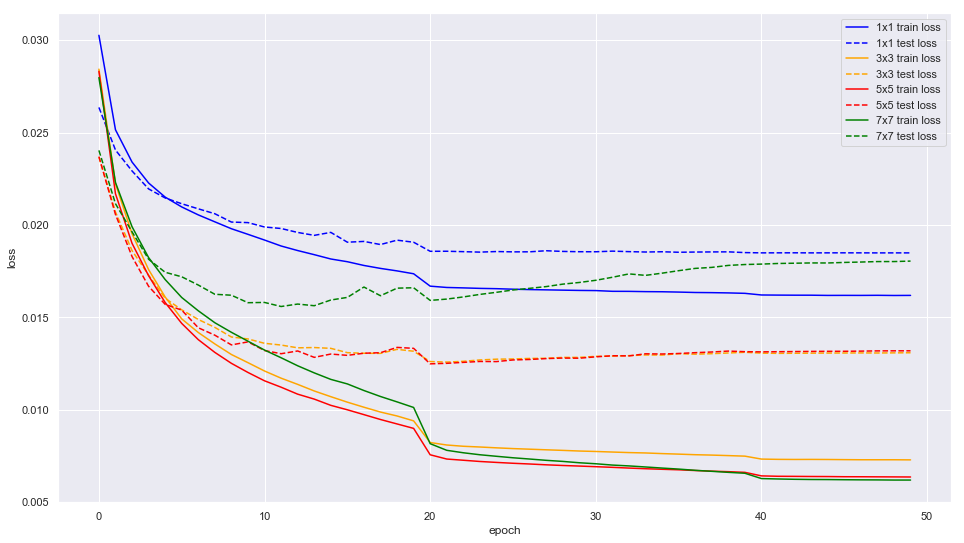

In [19]:
results_1 = load_results("results/results_filter_1")
results_3 = load_results("results/results_filter_3")
results_5 = load_results("results/results_filter_5")
results_7 = load_results("results/results_filter_7")

plt.figure(figsize=(16,9))
plt.plot(results_1[1], label="1x1 train loss", color="blue")
plt.plot(results_1[3], label="1x1 test loss", color="blue", linestyle="--")
plt.plot(results_3[1], label="3x3 train loss", color="orange")
plt.plot(results_3[3], label="3x3 test loss", color="orange", linestyle="--")
plt.plot(results_5[1], label="5x5 train loss", color="red")
plt.plot(results_5[3], label="5x5 test loss", color="red", linestyle="--")
plt.plot(results_7[1], label="7x7 train loss", color="green")
plt.plot(results_7[3], label="7x7 test loss", color="green", linestyle="--")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.savefig("plots/results_filter_sizes.png")

### Different number of filters

In [7]:
net_filters8 = NetExperiment(num_filters=8)
net_filters32 = NetExperiment(num_filters=32)
net_filters64 = NetExperiment(num_filters=64)
net_filters128 = NetExperiment(num_filters=128)

loss_func = nn.CrossEntropyLoss()
n_epochs = 50

print()
print("8 filters")
net_filters8.cuda()
optimizer = optim.SGD(net_filters8.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 40], gamma=0.1)
results_8 = train(net_filters8, optimizer, loss_func, scheduler, n_epochs, train_loader_experiments, test_loader)
save_results(results_8, "results/results_filters_8")

print()
print("32 filters")
net_filters32.cuda()
optimizer = optim.SGD(net_filters32.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 40], gamma=0.1)
results_32 = train(net_filters32, optimizer, loss_func, scheduler, n_epochs, train_loader_experiments, test_loader)
save_results(results_32, "results/results_filters_32")

print()
print("64 filters")
net_filters64.cuda()
optimizer = optim.SGD(net_filters64.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 40], gamma=0.1)
results_64 = train(net_filters64, optimizer, loss_func, scheduler, n_epochs, train_loader_experiments, test_loader)
save_results(results_64, "results/results_filters_64")

print()
print("128 filters")
net_filters128.cuda()
optimizer = optim.SGD(net_filters128.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 40], gamma=0.1)
results_128 = train(net_filters128, optimizer, loss_func, scheduler, n_epochs, train_loader_experiments, test_loader)
save_results(results_128, "results/results_filters_128")


8 filters
[2019-04-14 19:20:28] EPOCH 1 / 50; train_loss: 0.03187514434814453, train_accuracy: 0.25956; test_loss: 0.027856732249259948, test_accuracy: 0.3798
[2019-04-14 19:20:42] EPOCH 2 / 50; train_loss: 0.025128330438137055, train_accuracy: 0.42884; test_loss: 0.023588351261615754, test_accuracy: 0.468
[2019-04-14 19:20:55] EPOCH 3 / 50; train_loss: 0.02257704136133194, train_accuracy: 0.48516; test_loss: 0.02179841068983078, test_accuracy: 0.5018
[2019-04-14 19:21:09] EPOCH 4 / 50; train_loss: 0.02083875230550766, train_accuracy: 0.52718; test_loss: 0.020634016048908233, test_accuracy: 0.532
[2019-04-14 19:21:22] EPOCH 5 / 50; train_loss: 0.019717552661895753, train_accuracy: 0.55282; test_loss: 0.019610017442703246, test_accuracy: 0.5527
[2019-04-14 19:21:37] EPOCH 6 / 50; train_loss: 0.01897946758031845, train_accuracy: 0.57044; test_loss: 0.018916516488790513, test_accuracy: 0.5694
[2019-04-14 19:21:49] EPOCH 7 / 50; train_loss: 0.018377831349372865, train_accuracy: 0.58592; t

[2019-04-14 19:32:15] EPOCH 6 / 50; train_loss: 0.014851608874797822, train_accuracy: 0.67012; test_loss: 0.014832008105516433, test_accuracy: 0.6731
[2019-04-14 19:32:31] EPOCH 7 / 50; train_loss: 0.01395673861861229, train_accuracy: 0.69082; test_loss: 0.014327259707450867, test_accuracy: 0.6802
[2019-04-14 19:32:47] EPOCH 8 / 50; train_loss: 0.013300570924282074, train_accuracy: 0.70512; test_loss: 0.014344226682186127, test_accuracy: 0.6813
[2019-04-14 19:33:03] EPOCH 9 / 50; train_loss: 0.012764339060187339, train_accuracy: 0.718; test_loss: 0.013869299054145813, test_accuracy: 0.6933
[2019-04-14 19:33:22] EPOCH 10 / 50; train_loss: 0.012249998768270015, train_accuracy: 0.7289; test_loss: 0.013478786331415176, test_accuracy: 0.7056
[2019-04-14 19:33:39] EPOCH 11 / 50; train_loss: 0.01178371138870716, train_accuracy: 0.73788; test_loss: 0.013157178235054016, test_accuracy: 0.7091
[2019-04-14 19:33:58] EPOCH 12 / 50; train_loss: 0.011409543570280074, train_accuracy: 0.7491; test_los

[2019-04-14 19:51:22] EPOCH 11 / 50; train_loss: 0.010269666514992714, train_accuracy: 0.77448; test_loss: 0.012452577251195907, test_accuracy: 0.7293
[2019-04-14 19:51:54] EPOCH 12 / 50; train_loss: 0.00973781802892685, train_accuracy: 0.78458; test_loss: 0.012429283165931702, test_accuracy: 0.7306
[2019-04-14 19:52:26] EPOCH 13 / 50; train_loss: 0.00931703946352005, train_accuracy: 0.79416; test_loss: 0.01253879024684429, test_accuracy: 0.7319
[2019-04-14 19:52:58] EPOCH 14 / 50; train_loss: 0.008835801894068717, train_accuracy: 0.80442; test_loss: 0.01241992971599102, test_accuracy: 0.7389
[2019-04-14 19:53:30] EPOCH 15 / 50; train_loss: 0.008397913881242275, train_accuracy: 0.81328; test_loss: 0.012677332615852356, test_accuracy: 0.7332
[2019-04-14 19:54:03] EPOCH 16 / 50; train_loss: 0.00798211341947317, train_accuracy: 0.82504; test_loss: 0.012635234335064888, test_accuracy: 0.7387
[2019-04-14 19:54:36] EPOCH 17 / 50; train_loss: 0.007625051213502884, train_accuracy: 0.83124; tes

[2019-04-14 20:51:45] EPOCH 16 / 50; train_loss: 0.005393821026831865, train_accuracy: 0.88318; test_loss: 0.012893008676171302, test_accuracy: 0.7555
[2019-04-14 20:54:15] EPOCH 17 / 50; train_loss: 0.00481635941401124, train_accuracy: 0.8946; test_loss: 0.013210603532195091, test_accuracy: 0.7534
[2019-04-14 20:56:46] EPOCH 18 / 50; train_loss: 0.004219813783317804, train_accuracy: 0.9085; test_loss: 0.014082536220550538, test_accuracy: 0.7451
[2019-04-14 20:59:15] EPOCH 19 / 50; train_loss: 0.003724068364202976, train_accuracy: 0.91892; test_loss: 0.014872887879610061, test_accuracy: 0.7431
[2019-04-14 21:01:46] EPOCH 20 / 50; train_loss: 0.003112773990780115, train_accuracy: 0.934; test_loss: 0.01541715825200081, test_accuracy: 0.75
[2019-04-14 21:04:13] EPOCH 21 / 50; train_loss: 0.0017954782098531723, train_accuracy: 0.9704; test_loss: 0.014253607723116875, test_accuracy: 0.764
[2019-04-14 21:06:40] EPOCH 22 / 50; train_loss: 0.0014793749088048934, train_accuracy: 0.98048; test_l

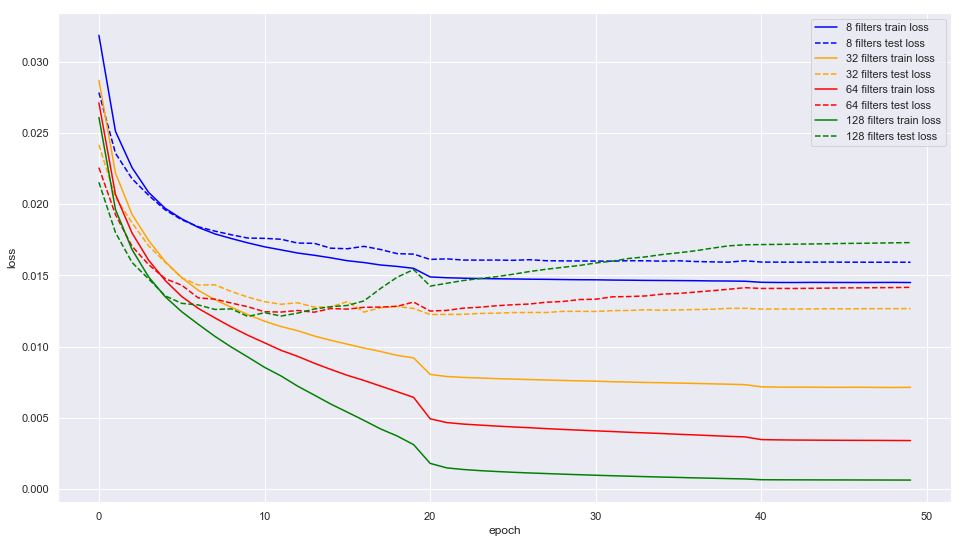

In [20]:
results_8 = load_results("results/results_filters_8")
results_32 = load_results("results/results_filters_32")
results_64 = load_results("results/results_filters_64")
results_128 = load_results("results/results_filters_128")

plt.figure(figsize=(16,9))
plt.plot(results_8[1], label="8 filters train loss", color="blue")
plt.plot(results_8[3], label="8 filters test loss", color="blue", linestyle="--")
plt.plot(results_32[1], label="32 filters train loss", color="orange")
plt.plot(results_32[3], label="32 filters test loss", color="orange", linestyle="--")
plt.plot(results_64[1], label="64 filters train loss", color="red")
plt.plot(results_64[3], label="64 filters test loss", color="red", linestyle="--")
plt.plot(results_128[1], label="128 filters train loss", color="green")
plt.plot(results_128[3], label="128 filters test loss", color="green", linestyle="--")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.savefig("plots/results_filter_number.png")

## Batch normalization vs dropout

In [14]:
net_baseline = NetExperiment()
net_bn = NetExperiment(bn=True)
net_dropout = NetExperiment(dropout=0.3)
net_bn_dropout = NetExperiment(bn=True, dropout=0.3)

loss_func = nn.CrossEntropyLoss()
n_epochs = 50

print()
print("baseline")
net_baseline.cuda()
optimizer = optim.SGD(net_baseline.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 40], gamma=0.1)
result_baseline = train(net_baseline, optimizer, loss_func, scheduler, n_epochs, train_loader_experiments, test_loader)
save_results(result_baseline, "results/result_baseline")

print()
print("batch normalization")
net_bn.cuda()
optimizer = optim.SGD(net_bn.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 40], gamma=0.1)
results_bn = train(net_bn, optimizer, loss_func, scheduler, n_epochs, train_loader_experiments, test_loader)
save_results(results_bn, "results/results_bn")

print()
print("dropout")
net_dropout.cuda()
optimizer = optim.SGD(net_dropout.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 40], gamma=0.1)
results_dropout = train(net_dropout, optimizer, loss_func, scheduler, n_epochs, train_loader_experiments, test_loader)
save_results(results_dropout, "results/results_dropout")

print()
print("batch normalization + dropout")
net_bn_dropout.cuda()
optimizer = optim.SGD(net_bn_dropout.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 40], gamma=0.1)
results_bn_dropout = train(net_bn_dropout, optimizer, loss_func, scheduler, n_epochs, train_loader_experiments, test_loader)
save_results(results_bn_dropout, "results/results_bn_dropout")


baseline
[2019-04-14 22:19:59] EPOCH 1 / 50; train_loss: 0.028475306344032288, train_accuracy: 0.35632; test_loss: 0.023952809524536132, test_accuracy: 0.4576
[2019-04-14 22:20:37] EPOCH 2 / 50; train_loss: 0.022222190454006197, train_accuracy: 0.5002; test_loss: 0.02047252299785614, test_accuracy: 0.5388
[2019-04-14 22:21:19] EPOCH 3 / 50; train_loss: 0.01939895732998848, train_accuracy: 0.56552; test_loss: 0.018653233587741853, test_accuracy: 0.5819
[2019-04-14 22:22:01] EPOCH 4 / 50; train_loss: 0.017449348462820053, train_accuracy: 0.6095; test_loss: 0.01755158333182335, test_accuracy: 0.6063
[2019-04-14 22:22:22] EPOCH 5 / 50; train_loss: 0.015975933820009232, train_accuracy: 0.6446; test_loss: 0.016148263520002364, test_accuracy: 0.6407
[2019-04-14 22:22:41] EPOCH 6 / 50; train_loss: 0.014811543310880661, train_accuracy: 0.67084; test_loss: 0.015014117968082427, test_accuracy: 0.6692
[2019-04-14 22:23:01] EPOCH 7 / 50; train_loss: 0.013945818001031876, train_accuracy: 0.69092; t

[2019-04-14 22:38:14] EPOCH 6 / 50; train_loss: 0.012749776256084443, train_accuracy: 0.71846; test_loss: 0.013709438902139664, test_accuracy: 0.7005
[2019-04-14 22:38:34] EPOCH 7 / 50; train_loss: 0.012258709123134613, train_accuracy: 0.73062; test_loss: 0.013563727444410324, test_accuracy: 0.7005
[2019-04-14 22:38:55] EPOCH 8 / 50; train_loss: 0.011895084074735641, train_accuracy: 0.73878; test_loss: 0.013334798538684845, test_accuracy: 0.7065
[2019-04-14 22:39:15] EPOCH 9 / 50; train_loss: 0.011534500004053115, train_accuracy: 0.74594; test_loss: 0.013370964869856835, test_accuracy: 0.7075
[2019-04-14 22:39:36] EPOCH 10 / 50; train_loss: 0.011222585569024087, train_accuracy: 0.75222; test_loss: 0.013176474624872208, test_accuracy: 0.7078
[2019-04-14 22:39:58] EPOCH 11 / 50; train_loss: 0.010962384143471718, train_accuracy: 0.75724; test_loss: 0.012925079825520516, test_accuracy: 0.721
[2019-04-14 22:40:16] EPOCH 12 / 50; train_loss: 0.010673872361779213, train_accuracy: 0.7626; test

[2019-04-14 22:56:28] EPOCH 11 / 50; train_loss: 0.016604109188318252, train_accuracy: 0.63098; test_loss: 0.017275157034397127, test_accuracy: 0.6153
[2019-04-14 22:56:44] EPOCH 12 / 50; train_loss: 0.01634169119477272, train_accuracy: 0.63734; test_loss: 0.017132649320364, test_accuracy: 0.6165
[2019-04-14 22:57:00] EPOCH 13 / 50; train_loss: 0.016035660964250565, train_accuracy: 0.64596; test_loss: 0.016949610602855682, test_accuracy: 0.6241
[2019-04-14 22:57:21] EPOCH 14 / 50; train_loss: 0.015843818477392198, train_accuracy: 0.6473; test_loss: 0.016878612834215163, test_accuracy: 0.6242
[2019-04-14 22:57:37] EPOCH 15 / 50; train_loss: 0.01570233029961586, train_accuracy: 0.6505; test_loss: 0.01664619116783142, test_accuracy: 0.6343
[2019-04-14 22:57:56] EPOCH 16 / 50; train_loss: 0.015469333152770996, train_accuracy: 0.65454; test_loss: 0.016407642632722853, test_accuracy: 0.6402
[2019-04-14 22:58:12] EPOCH 17 / 50; train_loss: 0.01530694473028183, train_accuracy: 0.66244; test_lo

[2019-04-14 23:13:32] EPOCH 16 / 50; train_loss: 0.015208547362089157, train_accuracy: 0.66344; test_loss: 0.0166039826631546, test_accuracy: 0.6349
[2019-04-14 23:13:53] EPOCH 17 / 50; train_loss: 0.015098873282670974, train_accuracy: 0.66656; test_loss: 0.016331023794412612, test_accuracy: 0.6417
[2019-04-14 23:14:11] EPOCH 18 / 50; train_loss: 0.014976029751300812, train_accuracy: 0.66932; test_loss: 0.016258180767297743, test_accuracy: 0.643
[2019-04-14 23:14:32] EPOCH 19 / 50; train_loss: 0.014879199336767197, train_accuracy: 0.66988; test_loss: 0.01653913332223892, test_accuracy: 0.6389
[2019-04-14 23:14:52] EPOCH 20 / 50; train_loss: 0.014725761601924896, train_accuracy: 0.674; test_loss: 0.01625449942946434, test_accuracy: 0.6407
[2019-04-14 23:15:12] EPOCH 21 / 50; train_loss: 0.014184692093133926, train_accuracy: 0.68622; test_loss: 0.015852005469799042, test_accuracy: 0.6486
[2019-04-14 23:15:33] EPOCH 22 / 50; train_loss: 0.014041264216899873, train_accuracy: 0.69032; test_

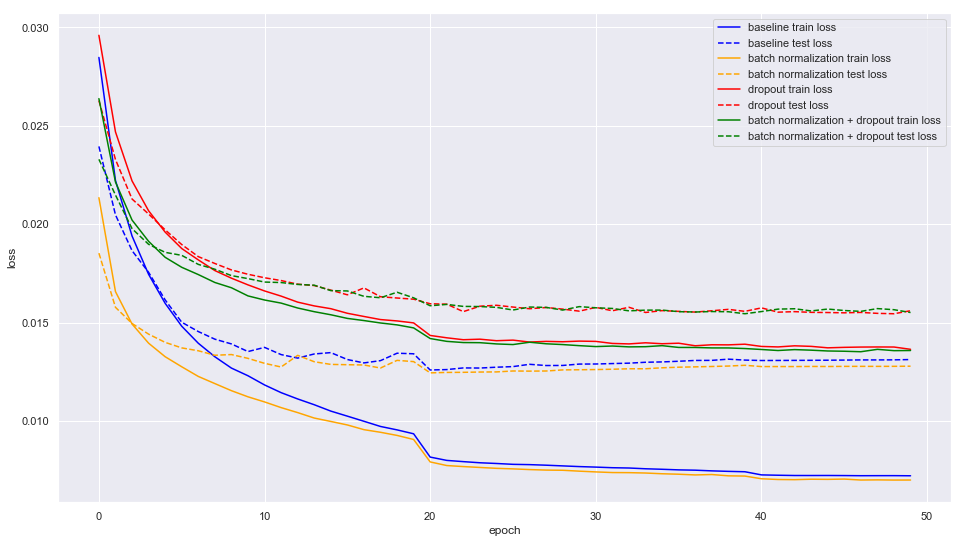

In [21]:
results_baseline = load_results("results/result_baseline")
results_bn = load_results("results/results_bn")
results_dropout = load_results("results/results_dropout")
results_bn_dropout = load_results("results/results_bn_dropout")

plt.figure(figsize=(16,9))
plt.plot(results_baseline[1], label="baseline train loss", color="blue")
plt.plot(results_baseline[3], label="baseline test loss", color="blue", linestyle="--")
plt.plot(results_bn[1], label="batch normalization train loss", color="orange")
plt.plot(results_bn[3], label="batch normalization test loss", color="orange", linestyle="--")
plt.plot(results_dropout[1], label="dropout train loss", color="red")
plt.plot(results_dropout[3], label="dropout test loss", color="red", linestyle="--")
plt.plot(results_bn_dropout[1], label="batch normalization + dropout train loss", color="green")
plt.plot(results_bn_dropout[3], label="batch normalization + dropout test loss", color="green", linestyle="--")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.savefig("plots/results_dropout_bn.png")

### Final model

Final network consists of blocks:
* 3x3 conv layer (32 filters, padding == 1)
* elu activation
* batch normalization
* 3x3 conv layer (32 filters, padding == 1)
* elu activation
* batch normalization
* max pooling 2x2
---
* 3x3 conv layer (64 filters, padding == 1)
* elu activation
* batch normalization
* 3x3 conv layer (64 filters, padding == 1)
* elu activation
* batch normalization
* max pooling 2x2
---
* 3x3 conv layer (128 filters, padding == 1)
* elu activation
* batch normalization
* 3x3 conv layer (128 filters, padding == 1)
* elu activation
* batch normalization
* max pooling 2x2
---
* fully connected layer ----> 10 outputs

In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.elu = nn.ELU()
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv5 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv6 = nn.Conv2d(128, 128, 3, padding=1)
        self.max_pool = nn.MaxPool2d((2,2))
        self.bn_32 = nn.BatchNorm2d(32)
        self.bn_64 = nn.BatchNorm2d(64)
        self.bn_128 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 4 * 4, 10)

    def forward(self, x):
        x = self.bn_32(self.elu(self.conv1(x)))
        x = self.bn_32(self.elu(self.conv2(x)))
        x = self.max_pool(x)
        x = self.bn_64(self.elu(self.conv3(x)))
        x = self.bn_64(self.elu(self.conv4(x)))
        x = self.max_pool(x)
        x = self.bn_128(self.elu(self.conv5(x)))
        x = self.bn_128(self.elu(self.conv6(x)))
        x = self.max_pool(x)
        x = x.view(-1, 128 * 4 * 4)
        x = self.fc1(x)
        return x
    
net = Net()

net.to(device)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (elu): ELU(alpha=1.0)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (max_pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (bn_32): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_64): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_128): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=2048, out_features=10, bias=True)
)

In [16]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(net.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50, 100], gamma=0.1)

n_epochs = 150

results_final = train(net, optimizer, loss_func, scheduler, n_epochs, train_loader, test_loader)
save_results(results_final, "results/results_final")

[2019-04-15 00:43:16] EPOCH 1 / 150; train_loss: 0.028219338710308076, train_accuracy: 0.3563; test_loss: 0.022097396659851075, test_accuracy: 0.4792
[2019-04-15 00:43:49] EPOCH 2 / 150; train_loss: 0.021439661911726, train_accuracy: 0.50978; test_loss: 0.016690308278799058, test_accuracy: 0.6203
[2019-04-15 00:44:22] EPOCH 3 / 150; train_loss: 0.018635406367778776, train_accuracy: 0.57774; test_loss: 0.01432510381937027, test_accuracy: 0.6803
[2019-04-15 00:44:59] EPOCH 4 / 150; train_loss: 0.017136805331707, train_accuracy: 0.61422; test_loss: 0.01325485160946846, test_accuracy: 0.7043
[2019-04-15 00:45:36] EPOCH 5 / 150; train_loss: 0.0160120115172863, train_accuracy: 0.64216; test_loss: 0.011679363626241683, test_accuracy: 0.7362
[2019-04-15 00:46:12] EPOCH 6 / 150; train_loss: 0.015165715876817703, train_accuracy: 0.66062; test_loss: 0.011814488342404365, test_accuracy: 0.7389
[2019-04-15 00:46:53] EPOCH 7 / 150; train_loss: 0.014556587584018708, train_accuracy: 0.67702; test_loss

[2019-04-15 01:21:50] EPOCH 56 / 150; train_loss: 0.007764585427939892, train_accuracy: 0.82944; test_loss: 0.006095359709113836, test_accuracy: 0.8677
[2019-04-15 01:22:34] EPOCH 57 / 150; train_loss: 0.007655366652309895, train_accuracy: 0.83048; test_loss: 0.006028656923770905, test_accuracy: 0.8681
[2019-04-15 01:23:17] EPOCH 58 / 150; train_loss: 0.0076851721572875975, train_accuracy: 0.82892; test_loss: 0.006007093112915755, test_accuracy: 0.8687
[2019-04-15 01:24:01] EPOCH 59 / 150; train_loss: 0.007593735731542111, train_accuracy: 0.83068; test_loss: 0.00602723013907671, test_accuracy: 0.8688
[2019-04-15 01:24:45] EPOCH 60 / 150; train_loss: 0.007616960094869137, train_accuracy: 0.83088; test_loss: 0.0059992338500916955, test_accuracy: 0.8713
[2019-04-15 01:25:29] EPOCH 61 / 150; train_loss: 0.007509694434702396, train_accuracy: 0.83434; test_loss: 0.0059812781177461145, test_accuracy: 0.8704
[2019-04-15 01:26:10] EPOCH 62 / 150; train_loss: 0.007540993687212467, train_accuracy

[2019-04-15 02:01:19] EPOCH 110 / 150; train_loss: 0.006683109913766384, train_accuracy: 0.8505; test_loss: 0.005593543854355812, test_accuracy: 0.8788
[2019-04-15 02:02:03] EPOCH 111 / 150; train_loss: 0.006758179024755955, train_accuracy: 0.84936; test_loss: 0.0055903846979141235, test_accuracy: 0.8786
[2019-04-15 02:02:47] EPOCH 112 / 150; train_loss: 0.006730671829283237, train_accuracy: 0.85044; test_loss: 0.005589076687395573, test_accuracy: 0.8784
[2019-04-15 02:03:32] EPOCH 113 / 150; train_loss: 0.006645785064697265, train_accuracy: 0.85212; test_loss: 0.005616735329478979, test_accuracy: 0.8781
[2019-04-15 02:04:15] EPOCH 114 / 150; train_loss: 0.006688299385607242, train_accuracy: 0.85316; test_loss: 0.005603858767449856, test_accuracy: 0.8771
[2019-04-15 02:04:58] EPOCH 115 / 150; train_loss: 0.0067204422572255135, train_accuracy: 0.85124; test_loss: 0.005595575735718012, test_accuracy: 0.8777
[2019-04-15 02:05:42] EPOCH 116 / 150; train_loss: 0.006698504462242127, train_ac

Model accuracy on test set: 0.8795


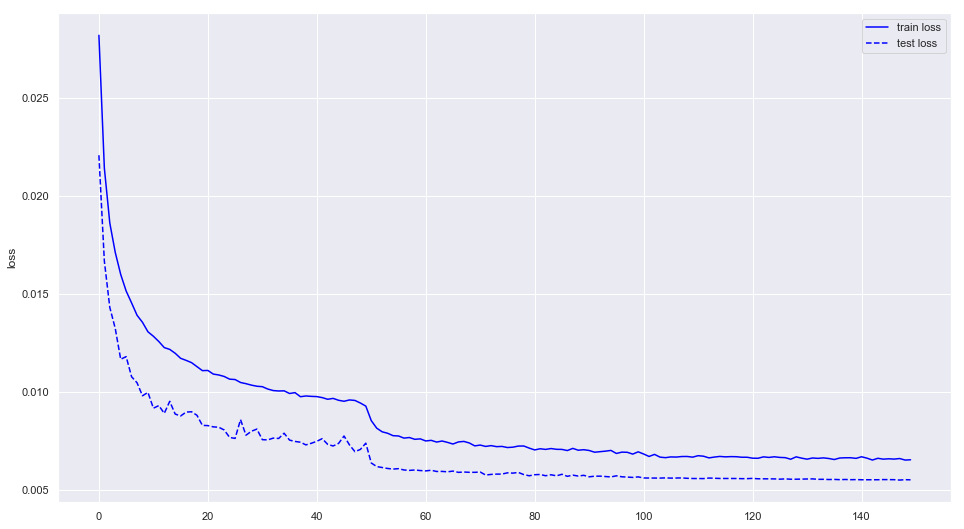

In [25]:
results_final = load_results("results/results_final")

plt.figure(figsize=(16,9))
plt.plot(results_final[1], label="train loss", color="blue")
plt.plot(results_final[3], label="test loss", color="blue", linestyle="--")
plt.ylabel('loss')
plt.legend()
plt.savefig("plots/results_final.png")

print("Model accuracy on test set: {}".format(results_final[2][-1]))

## Pretrained model

trained using Google Colab

In [7]:
resnet = torchvision.models.resnet101(pretrained=False)
resnet_num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(resnet_num_ftrs, 10)
loss_func = nn.CrossEntropyLoss()

resnet.load_state_dict(torch.load('resnet101final.pth'))
resnet.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [23]:
transform_test_resnet = torchvision.transforms.Compose([torchvision.transforms.Resize((224, 224)),
                                                        torchvision.transforms.ToTensor(),
                                                        torchvision.transforms.Normalize(train_mean, train_std)])

test_set_resnet = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=False, transform=transform_test_resnet)
                                                       
test_loader_resnet = torch.utils.data.DataLoader(test_set_resnet, batch_size=64,
                                         shuffle=False, num_workers=2)

results_resnet = test(resnet, test_loader_resnet, loss_func)

print("ResNet model accuracy on test set: {}".format(results_resnet[0]))

ResNet model accuracy on test set: 0.9721
